# Linearized BP Matrix

In this notebook, we'll run a quick proof-of-concept experiment in which we'll show that the linearized nonbacktracking matrix for belief propagation can indeed detect communities well outside the regimes in which both hypergraph Louvain and graph-based methods can work. To emphasize, this is very **proof-of-concept**. As we'll see, there's both some theory in need of understanding and various important improvements to the code. 

In [1]:
using HypergraphDetectability
using DataFrames
using Clustering
using Statistics
using RCall
using Arpack

In [2]:
n  = 100
c₂ = 5
c₃ = 5
z  = 1 .+ (1:n .> n/2);

In [3]:
function experiment(P₂, P₃, n, c₂, c₃, z)
    P2, P3,  MI, EV = zeros(0), zeros(0), zeros(0), zeros(0)
    for p₂ ∈ P₂, p₃ ∈ P₃
        H = detectabilityData(n, c₂, c₃, p₂, p₃);
        BP_mat, ix = linearizedBPMatrix(H, z);
        try 
            E = Arpack.eigs(BP_mat; nev = 2, ritzvec = true)
            
            for ev ∈ 1:2
                v = E[2][:,ev]
                u = aggregateEigenvector(v, ix)
                if !(mean(abs.(imag.(u))) ≈ 0)
                    mi = 0.0
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                else
                    clusters = 1 .+ (real.(u) .> 0)
                    mi = mutualinfo(clusters, z)
                    append!(P2, p₂)
                    append!(P3, p₃)
                    append!(MI, mi)
                    append!(EV, ev)
                end
            end
        catch e
            nothing
        end
    end
    DF = DataFrame(
        P_2 = P2, 
        P_3 = P3, 
        MI = MI, 
        EV = EV
    )
    return DF
end

experiment (generic function with 1 method)

**Note**: the below cell takes quite a while to run!! Dropping the resolution of the grid or the number of repetitions is encouraged. 

In [4]:
n_reps = 20
DF = DataFrame()

# for rep ∈ 1:n_reps
#     println("round $(rep)")
#     df = experiment(0:0.02:1, 0:0.02:1, n, c₂, c₃, z);
#     append!(DF, df)
# end

The following block can be used for caching the results of the above computation for easy subsequent access. 

In [13]:
R"""
# library(tidyverse)
# df <- tibble($(DF))
# df %>% write_csv("throughput/linearized-bp-heatmap.csv")
""";

RObject{VecSxp}
# A tibble: 101,322 x 4
     P_2   P_3     MI    EV
   <dbl> <dbl>  <dbl> <dbl>
 1     0  0    0          1
 2     0  0    1          2
 3     0  0.02 0          1
 4     0  0.02 1          2
 5     0  0.04 0.0186     1
 6     0  0.04 1          2
 7     0  0.06 0          1
 8     0  0.06 1          2
 9     0  0.08 0          1
10     0  0.08 1          2
# … with 101,312 more rows


## Visualizations

Now we're ready to visualize the results. First, we'll separately plot the recovery results when using the first and second eigenvectors separately. 

┌ Warning: RCall.jl: ── Attaching packages ─────────────────────────────────────── tidyverse 1.3.0 ──
│ ✔ ggplot2 3.3.2     ✔ purrr   0.3.4
│ ✔ tibble  3.0.3     ✔ dplyr   1.0.0
│ ✔ tidyr   1.1.0     ✔ stringr 1.4.0
│ ✔ readr   1.3.1     ✔ forcats 0.5.0
│ ── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
│ ✖ dplyr::filter() masks stats::filter()
│ ✖ dplyr::lag()    masks stats::lag()
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Loading required package: viridisLite
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Parsed with column specification:
│ cols(
│   P_2 = col_double(),
│   P_3 = col_double(),
│   MI = col_double(),
│   EV = col_double()
│ )
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: `summarise()` regrouping output by 'P_2', 'P_3' (override with `.groups` argument)
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


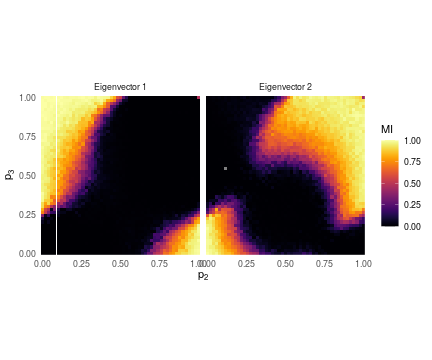

RObject{VecSxp}


In [5]:
R"""
library(tidyverse)
library(viridis)

df <- read_csv("throughput/linearized-bp-heatmap.csv")

df <- df %>%
    group_by(P_2, P_3, EV) %>% 
    summarise(MI = mean(MI, na.rm = T)) %>% 
    mutate(EV = paste0("Eigenvector ", EV))

p <- df %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = MI) + 
    geom_tile() + 
    theme_minimal() + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1)) + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    facet_wrap(~EV)

ggsave("fig/linearized-bp-heatmap-2-panel.png", p,  width = 7, height = 3)
p
"""


We can make an attractive combined plot in which the color of the tile corresponds to the eigenvector used to construct it. Paler tiles correspond to partial or failed recoveries, pink tiles correspond to recovery from the first eigenvector, and blue tiles to recoveries from the second eigenvector. 

There are labelling issues; due to the way I constructed this particular plot, it is difficult to get a professional legend giving a scale for the color shade intensity. Work in progress. 

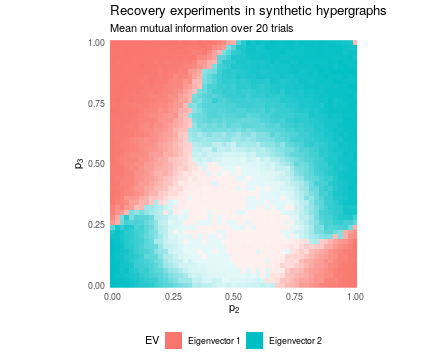

RObject{VecSxp}


In [6]:
R"""
p <- df %>% 
    group_by(P_2, P_3) %>% 
    filter(MI == max(MI)) %>% 
    mutate(MI = MI * (-1)^(EV == "Eigenvector 1")) %>% 
    mutate(f = MI > 0) %>% 
    ggplot() + 
    aes(x = P_2, y = P_3, fill = EV, alpha = abs(MI)) + 
    geom_tile() + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0)) + 
    scale_y_continuous(expand = c(0,0)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    guides(alpha = FALSE) + 
    theme(legend.position = "bottom") + 
    ggtitle("Recovery experiments in synthetic hypergraphs", 
            subtitle = "Mean mutual information over 20 trials")

ggsave("fig/linearized-bp-heatmap.png", p,  width = 4, height = 4)
p
"""

In [639]:
R"""

C = $(c₂)
D = $(c₃)

curve <- tibble(P_2 = seq(0, 1, 0.00001)) %>% 
    mutate(l_2 = 2*P_2 - 1,
           P_3 = (1 + 3*sqrt((1 - l_2^2*C)/(2*D)))/4,
           Q_3 = (1 - 3*sqrt((1 - l_2^2*C)/(2*D)))/4)

""";

┌ Warning: RCall.jl: Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
│ Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


┌ Warning: RCall.jl: Warning: Removed 136756 row(s) containing missing values (geom_path).
│ Warning: Removed 136756 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


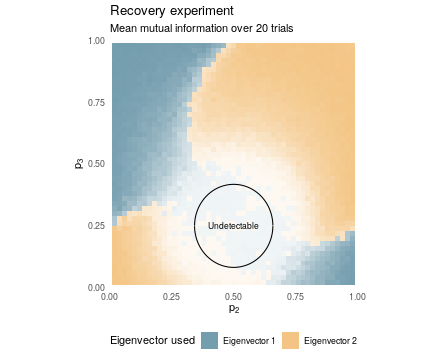

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 136756 row(s) containing missing values (geom_path).
│ Warning: Removed 136756 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [672]:
R"""
inauguration_2021 <- c("#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341","#f7dc6a")
p <- df %>% 
    group_by(P_2, P_3) %>% 
    filter(MI == max(MI)) %>% 
    mutate(MI = MI * (-1)^(EV == "Eigenvector 1")) %>% 
    mutate(f = MI > 0) %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = EV, alpha = abs(MI))) + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank()) + 
    coord_fixed() + 
    guides(alpha = FALSE, fill = guide_legend(title = "Eigenvector used")) + 
    theme(legend.position = "bottom") + 
    ggtitle("Recovery experiment", 
            subtitle = "Mean mutual information over 20 trials") + 
    geom_line(aes(x = P_2, y = P_3), data = curve) + 
    geom_line(aes(x = P_2, y = Q_3), data = curve) + 
    scale_fill_manual(values = inauguration_2021[2:3]) + 
    annotate("text", x = 0.5, y = 0.25, label = "Undetectable", size = 3)

ggsave("fig/linearized-bp-heatmap-with-annotation.png", p,  width = 6, height = 5)
p
"""

┌ Warning: RCall.jl: Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
│ Warning in sqrt((1 - l_2^2 * C)/(2 * D)) : NaNs produced
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160
┌ Warning: RCall.jl: Warning: Removed 68378 row(s) containing missing values (geom_path).
│ Warning: Removed 68378 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


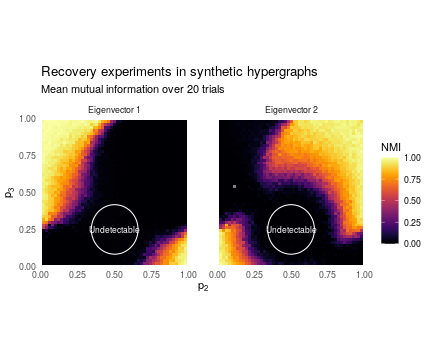

RObject{VecSxp}


┌ Warning: RCall.jl: Warning: Removed 68378 row(s) containing missing values (geom_path).
│ Warning: Removed 68378 row(s) containing missing values (geom_path).
└ @ RCall /home/phil/.julia/packages/RCall/Qzssx/src/io.jl:160


In [671]:
R"""
inauguration_2021 <- c("#5445b1", "#749dae", "#f3c483", "#5c1a33", "#cd3341","#f7dc6a")

C = $(c₂)
D = $(c₃)

curve <- tibble(expand.grid(P_2 = seq(0, 1, 0.00001), EV = c("Eigenvector 1", "Eigenvector 2"))) %>% 
    mutate(l_2 = 2*P_2 - 1,
           P_3 = (1 + 3*sqrt((1 - l_2^2*C)/(2*D)))/4,
           Q_3 = (1 - 3*sqrt((1 - l_2^2*C)/(2*D)))/4)


p <- df %>% 
    ggplot() + 
    geom_tile(aes(x = P_2, y = P_3, fill = MI)) + 
    theme_minimal() + 
    scale_x_continuous(expand = c(0,0), limits = c(0, 1)) + 
    scale_y_continuous(expand = c(0,0), limits = c(0, 1)) + 
    xlab(expression(p[2])) + 
    ylab(expression(p[3])) + 
    theme(panel.grid = element_blank(), panel.spacing = unit(2, "lines")) + 
    coord_fixed() + 
    facet_wrap(~EV) + 
    guides(alpha = FALSE, fill = guide_colorbar(title = "NMI")) + 
    ggtitle("Recovery experiments in synthetic hypergraphs", 
            subtitle = "Mean mutual information over 20 trials") + 
    geom_line(aes(x = P_2, y = P_3), data = curve, color = "white") + 
    geom_line(aes(x = P_2, y = Q_3), data = curve, color = "white") + 
    annotate("text", x = 0.5, y = 0.25, label = "Undetectable", color = "white", size = 3) + 
    scale_fill_viridis(option = "inferno", limits = c(0, 1))

ggsave("fig/linearized-bp-heatmap-with-annotation-2-panel.png", p,  width = 8, height = 4)
p
"""